### 1. Import files from Google Drive and extract them into data folder

In [1]:
import gdown
# Google drive public shared folder ID
id = "1vdm8b0ewDslPVvubA8emwDYHUGtwx5pT"
gdown.download_folder(id=id,output="../data", quiet=True, use_cookies=False)

['../data\\bike_data.7z']

In [2]:
import py7zr
# Extract files from 7zip file
with py7zr.SevenZipFile('../data/bike_data.7z', mode='r') as z:
    z.extractall("../data")

#### 2. Read files

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

df = pd.read_csv('../data/accidentsVelo.csv',low_memory=False)
df.head()

Num_Acc        date    an     mois      jour   hrmn dep    com  \
0  200500000030  2005-01-13  2005  janvier     jeudi  19:45  62  62331   
1  200500000034  2005-01-19  2005  janvier  mercredi  10:45  62  62022   
2  200500000078  2005-01-26  2005  janvier  mercredi  13:15  02  02173   
3  200500000093  2005-01-03  2005  janvier     lundi  13:30  02  02810   
4  200500000170  2005-01-29  2005  janvier    samedi  18:30  76  76196   

      lat   long  ...  secuexist  equipement  obs  obsm  choc  manv  \
0    50.3   2.84  ...          0           0  0.0   2.0   8.0  11.0   
1       0      0  ...          0           0  0.0   2.0   1.0   1.0   
2       0      0  ...          1           2  0.0   2.0   1.0   1.0   
3  49.255  3.094  ...          0           0  0.0   2.0   3.0  21.0   
4       0      0  ...          1           9  0.0   2.0   4.0   2.0   

        vehiculeid  typevehicules  manoeuvehicules  numVehicules  
0  200500000030B02             18               17           1.0  
1  200500000034B02             10               15           1.0  
2  200500000078B02              7               15           1.0  
3  200500000093B02              7               21           1.0  
4  200500000170A01             10                2           1.0  

[5 rows x 39 columns]

### 3. Some columns have mixed type values. Lets start by removing NA's first on lat and long columns only

In [4]:
num_rows = len(df)
df = df.loc[(df["lat"].notna() & df["long"].notna())]
num_rows_not_na = len(df)
print("----\nRemoved NA's rows : %d\n----" % (num_rows -num_rows_not_na) )
df[["lat","long"]].info()

----
Removed NA's rows : 268
----
<class 'pandas.core.frame.DataFrame'>
Index: 74490 entries, 0 to 74757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lat     74490 non-null  object
 1   long    74490 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


### 4. Convert lat and long cols to float

In [5]:
df['lat'] = df['lat'].apply(lambda x: float(str(x).replace(',', '.')))
df['long'] = df['long'].apply(lambda x: float(str(x).replace(',', '.')))

df[["lat","long"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 74490 entries, 0 to 74757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     74490 non-null  float64
 1   long    74490 non-null  float64
dtypes: float64(2)
memory usage: 1.7 MB


### 5. Checking zeros on lat and long cols and total number of cols

In [6]:
count_lat = df['lat'].value_counts()[0]
count_long = df['long'].value_counts()[0]
rows = len(df)

results = pd.DataFrame(data={"lat_with_zero":[count_lat], "long_with_zero":[count_long],"Total number of rows": [rows]})
results

lat_with_zero  long_with_zero  Total number of rows
0          42084           43131                 74490

### 6. Remove rows where lat and long columns are not 0

In [7]:
df_filtered = df.loc[(df['lat'] != 0) & (df['long'] != 0)].copy()
print("Non zero coordinates data frame has %d rows" %(len(df_filtered)))

Non zero coordinates data frame has 31355 rows


### 7. Convert to a proper geodataframe

epsg:4326


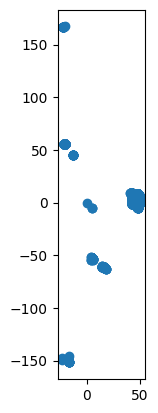

In [66]:
import geopandas as gp
# Convert longitude and latitude to a geometric Point object
points_gdf = gp.GeoDataFrame(df_filtered, geometry=gp.points_from_xy(df_filtered.lat, df_filtered.long))
# Convert DataFrame to GeoDataFrame
points_gdf = points_gdf.set_crs('epsg:4326')
points_gdf.plot(aspect='equal')
print(points_gdf.crs)

#### Its seems the coordinates are inverted, let's fix this

epsg:27561


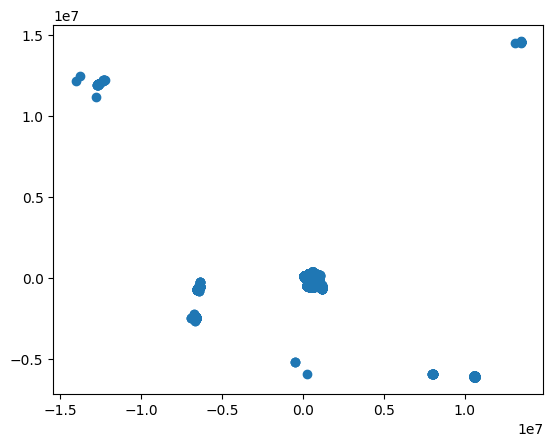

In [67]:
# Convert longitude and latitude to a geometric Point object
points_gdf = gp.GeoDataFrame(df_filtered, geometry=gp.points_from_xy(df_filtered.long, df_filtered.lat))
# Convert DataFrame to GeoDataFrame
points_gdf = points_gdf.set_crs('epsg:4326').to_crs('epsg:27561')
points_gdf.plot()
print(points_gdf.crs)

### 8. Plot France department limits and bike accident points

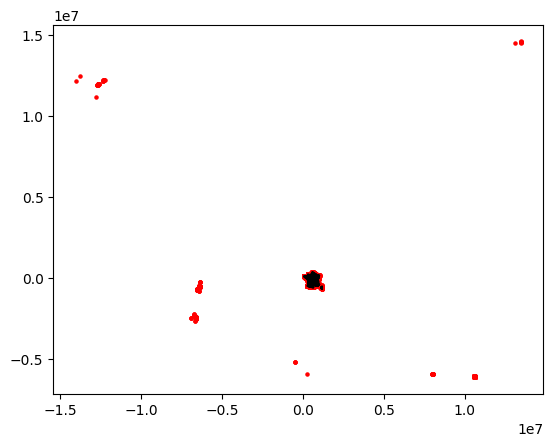

In [68]:
import matplotlib.pyplot as plt

france_gdf = gp.read_file("../data/france_dep.geojson")
france_gdf = france_gdf.to_crs('epsg:27561')

ax = points_gdf.plot(marker='o', color='red', markersize=5,aspect=1)
france_gdf.plot(ax=ax, color='white', edgecolor='black')
plt.show()

### And we grab and plot only the points inside France and plot bicycle accident points together

In [69]:
points_within = gp.sjoin(points_gdf,france_gdf,predicate='within')

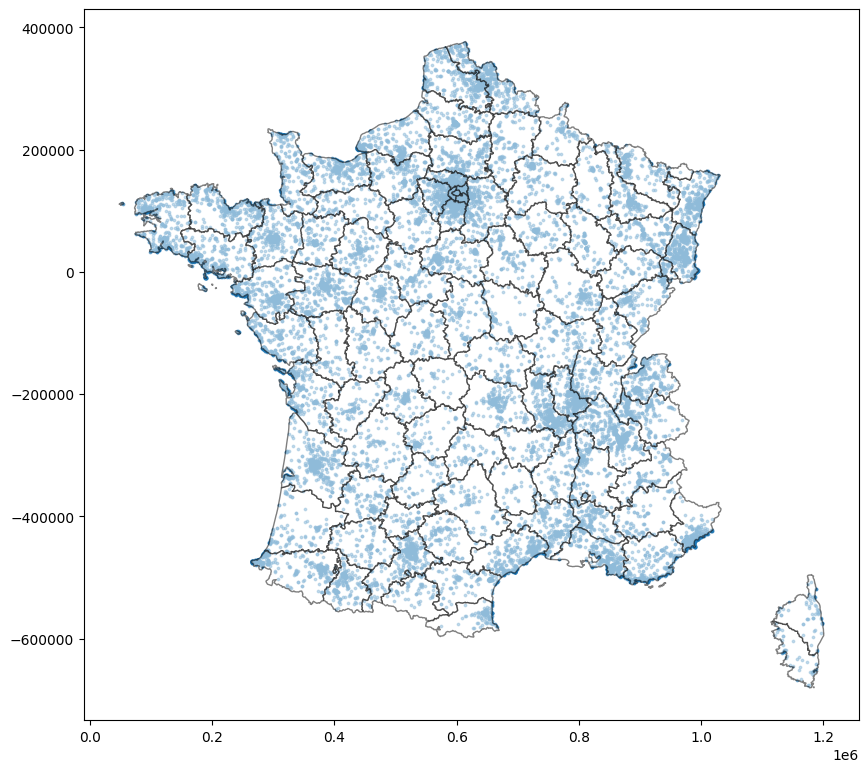

In [70]:
ax = points_within.plot(legend=True, markersize=3,alpha=0.5,figsize=(10,10))
france_gdf.plot(ax=ax, color='white', alpha=0.5, edgecolor="k")
plt.show()

#### 9. Checking if the gravity of the accident can be spatially explained

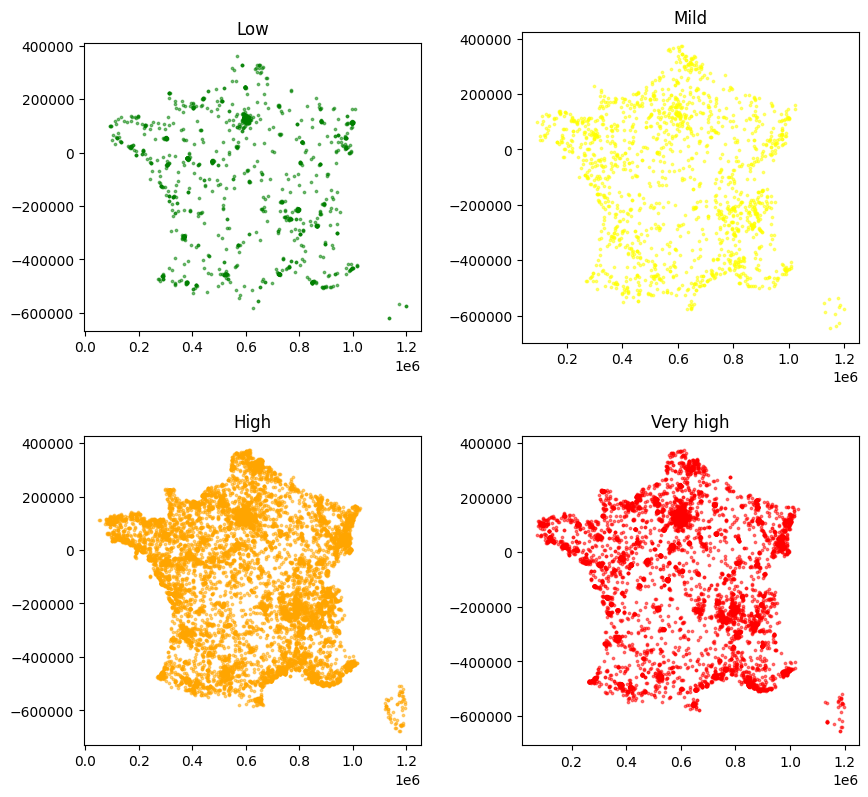

<Axes: xlabel='gravity', ylabel='count'>

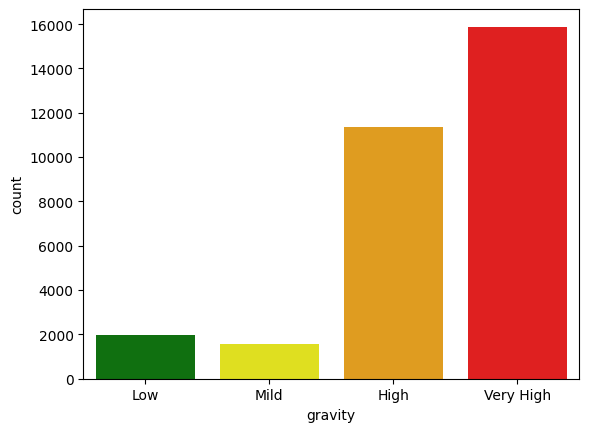

In [71]:
import seaborn as sns

fig, axs = plt.subplots(2, 2)


points_within_grav_1 = points_within.loc[points_within['grav'] == 1]
points_within_grav_1.plot(ax=axs[0, 0],markersize=3,alpha=0.5,color='green')
axs[0, 0].set_title("Low")

points_within_grav_2 = points_within.loc[points_within['grav'] == 2]
points_within_grav_2.plot(ax=axs[0, 1],markersize=3,alpha=0.5,color='yellow')
axs[0, 1].set_title("Mild")

axs[1, 0].sharex(axs[0, 0])

points_within_grav_3 = points_within.loc[points_within['grav'] == 3]
points_within_grav_3.plot(ax=axs[1, 0],markersize=3,alpha=0.5,color='orange')
axs[1, 0].set_title("High")

points_within_grav_4 = points_within.loc[points_within['grav'] == 4]
points_within_grav_4.plot(ax=axs[1, 1],markersize=3,alpha=0.5,color='red')
axs[1, 1].set_title("Very high")

fig.set_size_inches(10,10)

plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.show()

gravity_df = pd.DataFrame(data={"Low":len(points_within_grav_1),
                                'Mild':len(points_within_grav_2),
                                "High":len(points_within_grav_3),
                                "Very High":len(points_within_grav_4)
                                },index=[0]).melt(var_name='gravity',value_name='count')

# Ploting also a bar plot
sns.barplot(data=gravity_df, x='gravity',y='count',palette=['green', 'yellow', 'orange', 'red'])

##### Despite the fact that the number of accidents informed as 'very high' gravity are higher than others, it seems that all accidents are spatially well distributed across the country. It is also evident that the number of accidents are concentrated in certain areas. Still, the gravity of an accident may also be subjective (or not well informed) in many cases. Since we are interested in where the accidents are occurring, let's instead check the density of accidents by region population, no matter the accident's gravity

#### 10. Merge accidents with department population

In [72]:
accidents_by_department = None

<Axes: >

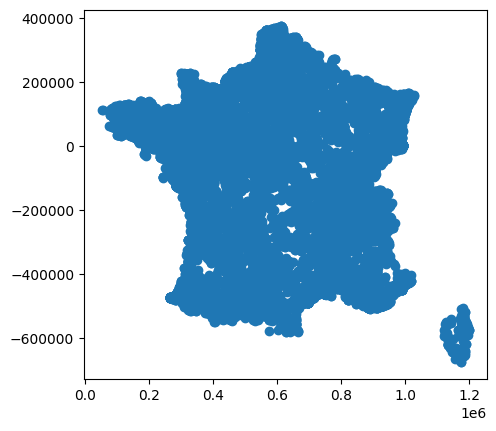

In [73]:
accidents_by_department = points_gdf.sjoin(france_gdf,predicate='within')
accidents_by_department.plot()

### and plot accidents by gravity and by department

In [129]:
accidents_by_department_acc = None

c:\Projects\venvs\work2\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


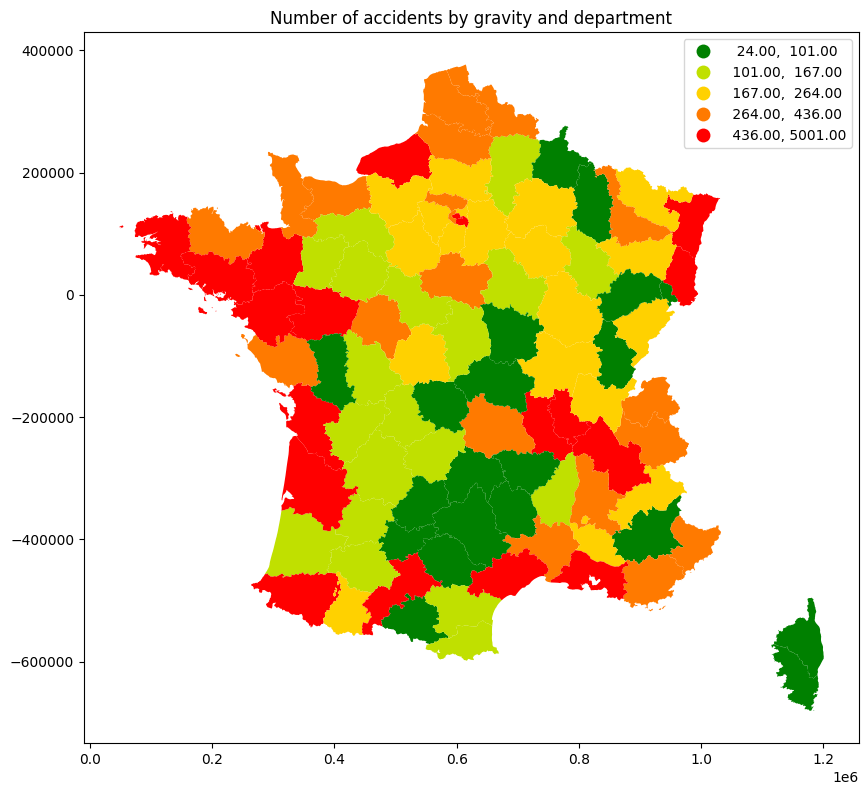

In [130]:
from matplotlib import colors

# Select relevelant columns and initialize a col, since grav contains numbers from 1 to 4
accidents_by_department_acc = accidents_by_department[['nom', 'geometry']]
accidents_by_department_acc['total_acc'] = 1

# Agregate (group) the sum of accidents (points) by deparment column, resulting in 96 multipoints rows per department
accidents_by_region = accidents_by_department_acc.dissolve(by='nom', aggfunc='sum',numeric_only=False)

# Remove index field names
france_gdf=france_gdf.loc[:,~france_gdf.columns.str.startswith('index_')]
accidents_by_region=accidents_by_region.loc[:,~accidents_by_region.columns.str.startswith('index_')]

# Merge france admin boundries with the previous aggregated data containing the sum
departments_by_accidents = gp.sjoin(france_gdf,accidents_by_region,how="inner",predicate="intersects")

# Define a palette of colors
cmap = colors.LinearSegmentedColormap.from_list("", ["green","yellow","orange","red"])

# Plot using quantiles as scheme
departments_by_accidents.plot(column = 'total_acc',scheme='quantiles', cmap=cmap,figsize=(10,10),legend=True);
plt.title("Number of accidents by gravity and department")
plt.show()

# Other scheme possibilities
# boxplot', 'equalinterval', 'fisherjenks', 'fisherjenkssampled', 'headtailbreaks', 'jenkscaspall', 'jenkscaspallforced', 
#'jenkscaspallsampled', 'maxp', 'maximumbreaks', 'naturalbreaks', 'quantiles', 'percentiles', 'prettybreaks', 'stdmean', 'userdefined'

### Quantile classification is well suited to linearly (evenly) distributed data, since we can have the same number of features or values in each class. However, the resulting map can often be misleading when the data is not evenly distributed, which is precisely our case :

c:\Projects\venvs\work2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


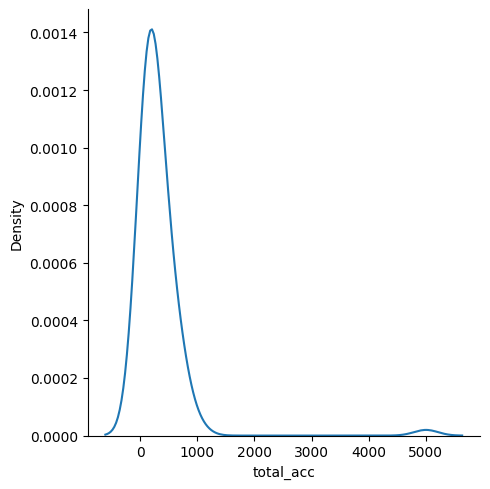

In [131]:
sns.displot(departments_by_accidents,x="total_acc", kind="kde")

In [132]:
departments_by_accidents[["nom","total_acc"]].sort_values("total_acc",ascending=False)

nom  total_acc
36                  Paris       5001
82         Maine-et-Loire        994
5         Ille-et-Vilaine        892
54                Gironde        704
33   Pyrénées-Atlantiques        703
..                    ...        ...
81                    Lot         56
48           Corse-du-Sud         49
95  Territoire de Belfort         38
30                 Lozère         37
50                 Creuse         24

[96 rows x 2 columns]

#### This map would reflect better the reality of our data : 

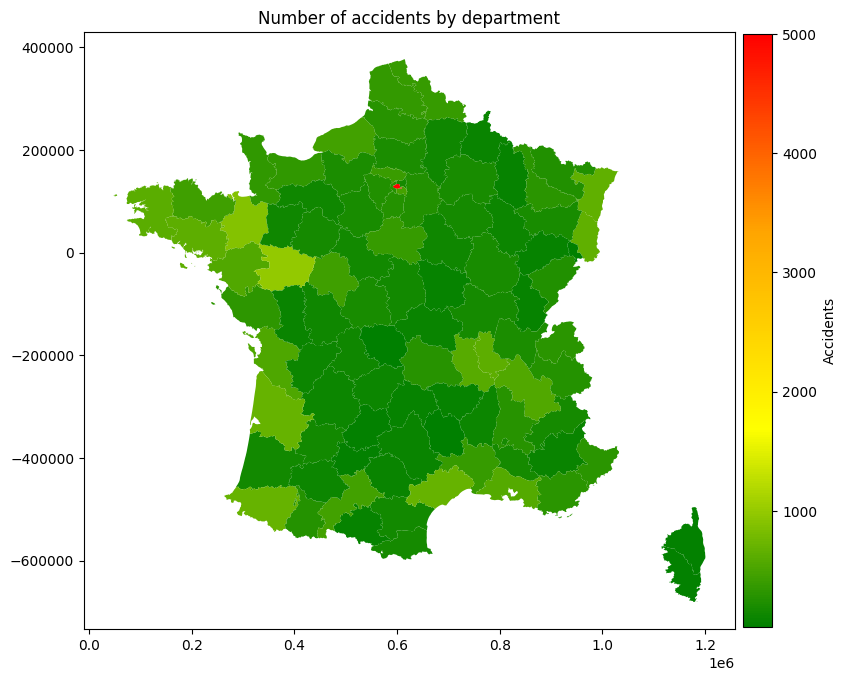

In [135]:
# Plot using without quantilles
departments_by_accidents.plot(column = 'total_acc', cmap=cmap,figsize=(10,10),legend=True,legend_kwds={
                    "shrink":.77,
                    "format": "%g",
                    'label': "Accidents",
                    "pad": 0.01,
                    #"ticks" : legend_intervals
                });
plt.title("Number of accidents by department")
plt.show()

#### 11. By using equal intervals, the total number of accidents in Paris is way higher than in most regions of france. Let's make the same plot by using region population instead

In [142]:
# Removing spaces and upper cases from cols of both dataframes
accidents_by_region.columns = [x.lower().replace(' ','') for x in accidents_by_region.columns]
accidents_by_department.columns = [x.lower().replace(' ','') for x in accidents_by_department.columns]

#### Load population data

In [144]:
population = pd.read_excel('../data/TCRD_004.xlsx',index_col=[0])
population_filtered = population[['nom','2023 (p)']].copy().rename(columns = {'2023 (p)':'pop_2023'})
population_filtered

nom  pop_2023
01                      Ain    671937
02                    Aisne    522791
03                   Allier    332443
04  Alpes-de-Haute-Provence    166654
05             Hautes-Alpes    139942
..                      ...       ...
91                  Essonne   1316053
92           Hauts-de-Seine   1642002
93        Seine-Saint-Denis   1682806
94             Val-de-Marne   1426748
95               Val-d'Oise   1274374

[96 rows x 2 columns]

#### Plot the number of accidents per 1000 habitanes per department

<Axes: >

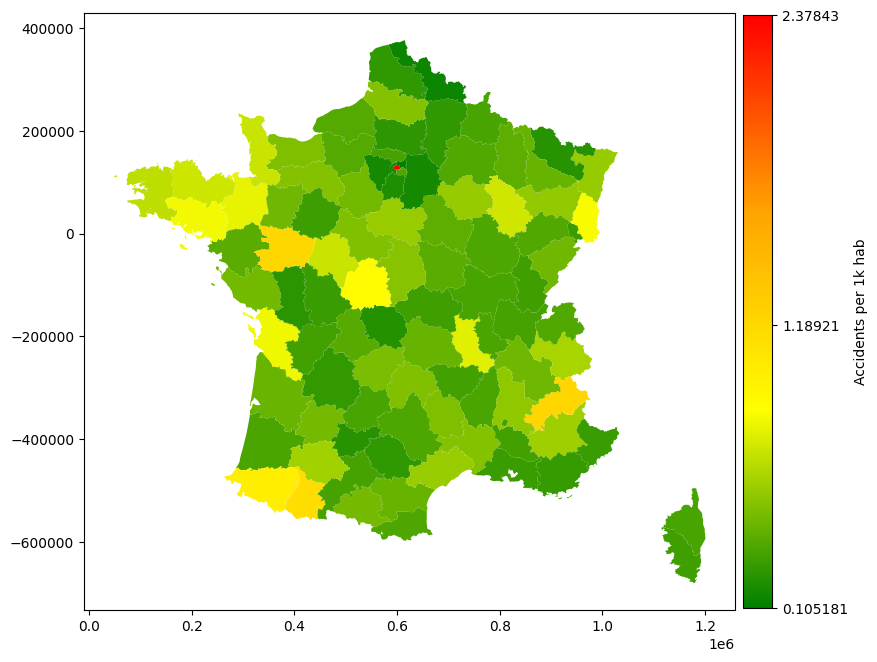

In [154]:
region_by_accidents_pop2023 = departments_by_accidents.merge(population_filtered,on='nom')
region_by_accidents_pop2023['acc_per_hab'] = (region_by_accidents_pop2023['total_acc'] / region_by_accidents_pop2023['pop_2023']) * 1000
region_by_accidents_pop2023.sort_values(by=['acc_per_hab'],ascending=[False]).head(10)
region_by_accidents_pop2023.plot(column='acc_per_hab',cmap=cmap,legend=True,figsize=(10,10),legend_kwds={
                    "shrink":.77,
                    "format": "%g",
                    'label': "Accidents per 1k hab",
                    "pad": 0.01,
                    "ticks" : [min(region_by_accidents_pop2023['acc_per_hab']),
                               max(region_by_accidents_pop2023['acc_per_hab']) / 2, 
                               max(region_by_accidents_pop2023['acc_per_hab'])]
                })

#### 12. Check if the cyclable rods can provide more info

<Axes: >

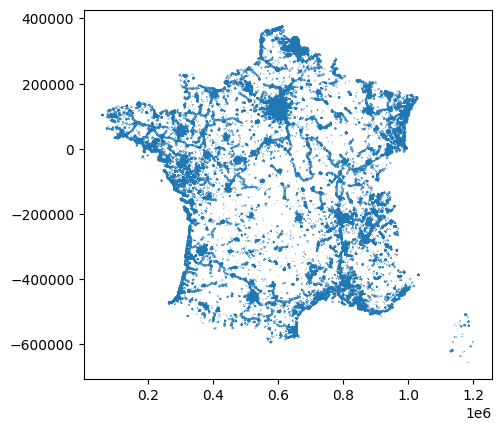

In [148]:
pistes_cyclable = gp.read_file("../data/france-20230901.geojson")
pistes_cyclable = pistes_cyclable.to_crs('epsg:27561')
pistes_cyclable.plot()

In [155]:
pistes_cyclable.head(1)

id_local     id_osm num_iti code_com_d       ame_d regime_d  \
0  geovelo_967104105_65226  967104105     NaN      65226  VOIE VERTE    AUTRE   

            sens_d  largeur_d local_d    statut_d  ... revet_g access_ame  \
0  UNIDIRECTIONNEL        NaN     NaN  EN SERVICE  ...     NaN        NaN   

     date_maj trafic_vit lumiere  d_service                           source  \
0  2021-07-25        5.0     NaN        NaN  Les contributeurs OpenStreetmap   

  project_c        ref_geo                                           geometry  
0      4326  OpenStreetmap  LINESTRING (411941.578 -496613.093, 411959.247...  

[1 rows x 28 columns]

# Check some colums and unique values

In [156]:
ame = pd.Series(u for u in pistes_cyclable['ame_d'].unique())
sens_d = pd.Series(u for u in pistes_cyclable['sens_d'].unique())
revet_g = pd.Series(u for u in pistes_cyclable['revet_g'].unique())
access_ame = pd.Series(u for u in pistes_cyclable['access_ame'].unique())
lumiere = pd.Series(u for u in pistes_cyclable['lumiere'].unique())

In [157]:
df_unique = pd.DataFrame({'track_type': ame, 'track_direction':sens_d,'track_material':revet_g,'track_acess':access_ame,'lumiere':lumiere})
df_unique

track_type  track_direction  \
0                                      VOIE VERTE  UNIDIRECTIONNEL   
1                                           AUTRE   BIDIRECTIONNEL   
2                                           AUCUN              NaN   
3   AMENAGEMENT MIXTE PIETON VELO HORS VOIE VERTE              NaN   
4                                  BANDE CYCLABLE              NaN   
5                                  PISTE CYCLABLE              NaN   
6                                COULOIR BUS+VELO              NaN   
7                                        GOULOTTE              NaN   
8              CHAUSSEE A VOIE CENTRALE BANALISEE              NaN   
9                     ACCOTEMENT REVETU HORS CVCB              NaN   
10                     DOUBLE SENS CYCLABLE BANDE              NaN   
11                                       VELO RUE              NaN   
12                     DOUBLE SENS CYCLABLE PISTE              NaN   
13                                            NaN              NaN   

   track_material    track_acess lumiere  
0             NaN            NaN     NaN  
1           LISSE  VELO DE ROUTE    True  
2         RUGUEUX         ROLLER   False  
3          MEUBLE            VTC     NaN  
4             NaN            VTT     NaN  
5             NaN            NaN     NaN  
6             NaN            NaN     NaN  
7             NaN            NaN     NaN  
8             NaN            NaN     NaN  
9             NaN            NaN     NaN  
10            NaN            NaN     NaN  
11            NaN            NaN     NaN  
12            NaN            NaN     NaN  
13            NaN            NaN     NaN

# Plot proportions of NA for each col

In [158]:
null_track_type_freq = pistes_cyclable['ame_d'].isnull().sum();
not_null_track_type_freq = pistes_cyclable['ame_d'].notnull().sum();

null_track_direction_freq = pistes_cyclable['sens_d'].isnull().sum();
not_null_track_direction_freq = pistes_cyclable['sens_d'].notnull().sum();

null_track_material_freq = pistes_cyclable['revet_g'].isnull().sum();
not_null_track_material_freq = pistes_cyclable['revet_g'].notnull().sum();

null_track_acess_freq = pistes_cyclable['access_ame'].isnull().sum();
not_null_track_acess_freq = pistes_cyclable['access_ame'].notnull().sum();

null_lumiere_freq = pistes_cyclable['lumiere'].isnull().sum();
not_null_lumiere_freq = pistes_cyclable['lumiere'].notnull().sum();

stats = pd.DataFrame({'Col' : ['Track type','Track dir','Track material','Track acess','Lumiere'],
                     'NA': [null_track_type_freq,null_track_direction_freq,null_track_material_freq,null_track_acess_freq,null_lumiere_freq],
                     'Not NA': [not_null_track_type_freq,not_null_track_direction_freq,not_null_track_material_freq,not_null_track_acess_freq,not_null_lumiere_freq]})

stats.set_index('Col')

stats

Col      NA  Not NA
0      Track type      13  293803
1       Track dir      61  293755
2  Track material  110912  182904
3     Track acess  260307   33509
4         Lumiere  223554   70262

# Since there are too many null values regarding track material, acess type and presence of ligtht, let's explore track type and track direction

In [159]:
# Starting by track type

pistes_cyclable_type_not_na = pistes_cyclable.loc[pistes_cyclable['ame_d'].notnull()]
print("Number of track types with null values : ", pistes_cyclable_type_not_na['ame_d'].isnull().sum())

Number of track types with null values :  0


## Visuzalize the top 5 departments by accidents and extract the first one

In [160]:
top5 = region_by_accidents_pop2023.sort_values(by=['acc_per_hab'],ascending=[False]).head(5)
print(top5[['nom','pop_2023']])
paris = top5.head(1)
paris

                     nom  pop_2023
36                 Paris   2102650
21          Hautes-Alpes    139942
82        Maine-et-Loire    828269
60       Hautes-Pyrénées    230583
33  Pyrénées-Atlantiques    697899


code    nom                                           geometry index_right  \
36   75  Paris  POLYGON ((598781.702 133337.696, 603566.179 13...       Paris   

    total_acc  pop_2023  acc_per_hab  
36       5001   2102650     2.378427

<Axes: >

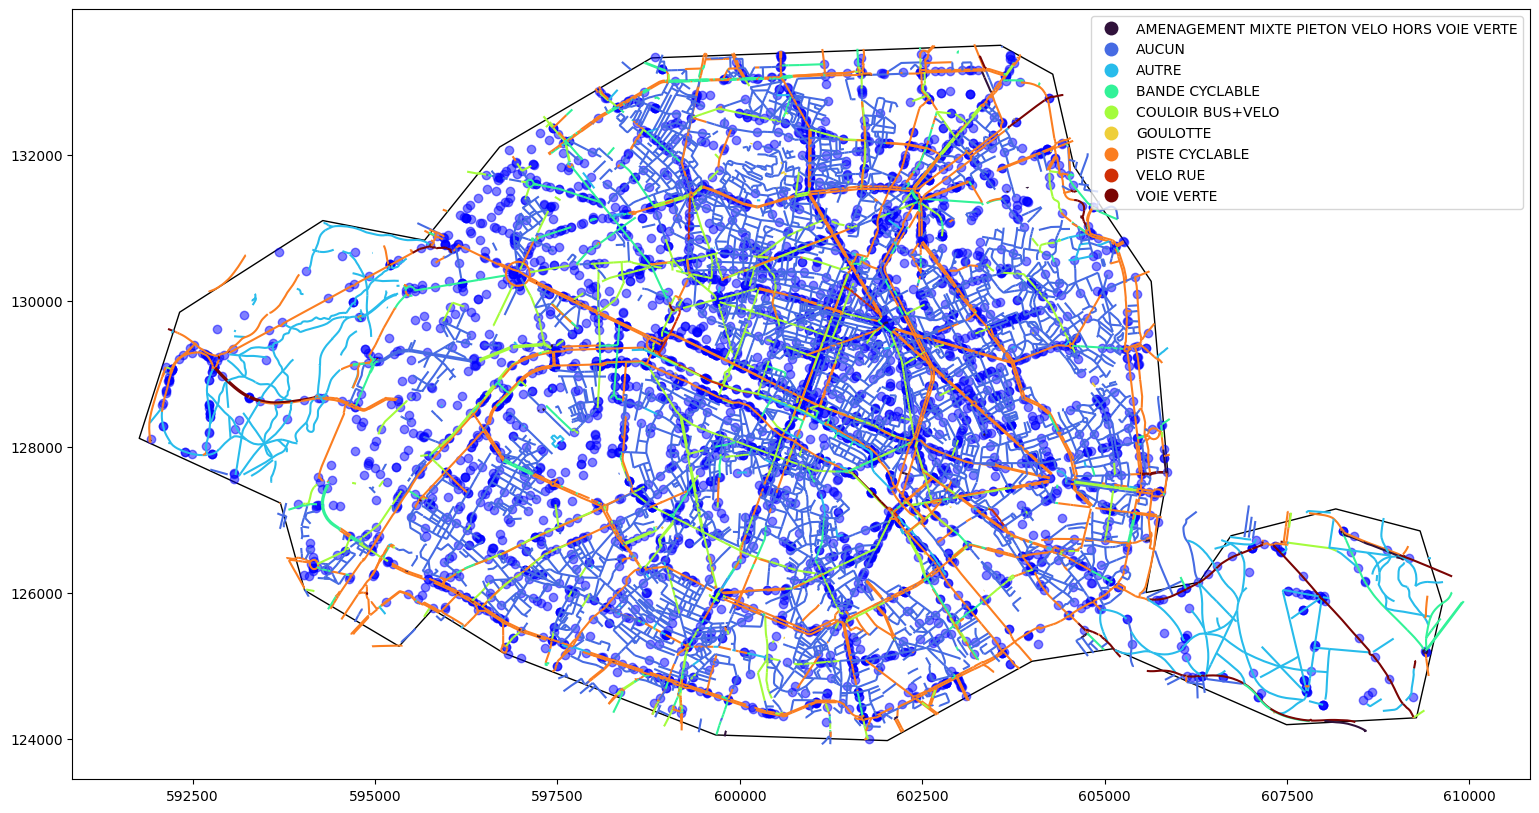

In [167]:

ax = paris.plot(color="white", edgecolor="black", figsize=(20, 10))

# Drop cols with index_ suffix
accidents_by_region_and_name = accidents_by_department.loc[:,~accidents_by_department.columns.str.startswith('index_')]
paris = paris.loc[:,~paris.columns.str.startswith('index_')]

# Intersect tracks with paris
region_intersect_track_type = gp.sjoin(pistes_cyclable_type_not_na, paris, predicate='intersects')
# Intersect accidents with paris
accidents_intersect_type = gp.sjoin(accidents_by_region_and_name, paris, predicate='within')
# Define a colormap
region_intersect_cmap = colors.LinearSegmentedColormap.from_list(region_intersect_track_type["ame_d"].unique(), list(reversed(["green","yellow","orange","red"])))

region_intersect_track_type.plot(ax=ax,cmap='turbo',column='ame_d',legend=True)
accidents_intersect_type.plot(ax=ax,color="blue",legend=True,alpha=0.5)

# There doesnt seem to have a direct relation between accidents and track type. Lets see about the track direction

In [168]:
# Starting by track type

pistes_cyclable_direction_not_na = pistes_cyclable.loc[pistes_cyclable['ame_d'].notnull()]
print("Number of track types with null values : ", pistes_cyclable_direction_not_na['ame_d'].isnull().sum())

Number of track types with null values :  0


c:\Projects\venvs\work2\lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<Axes: >

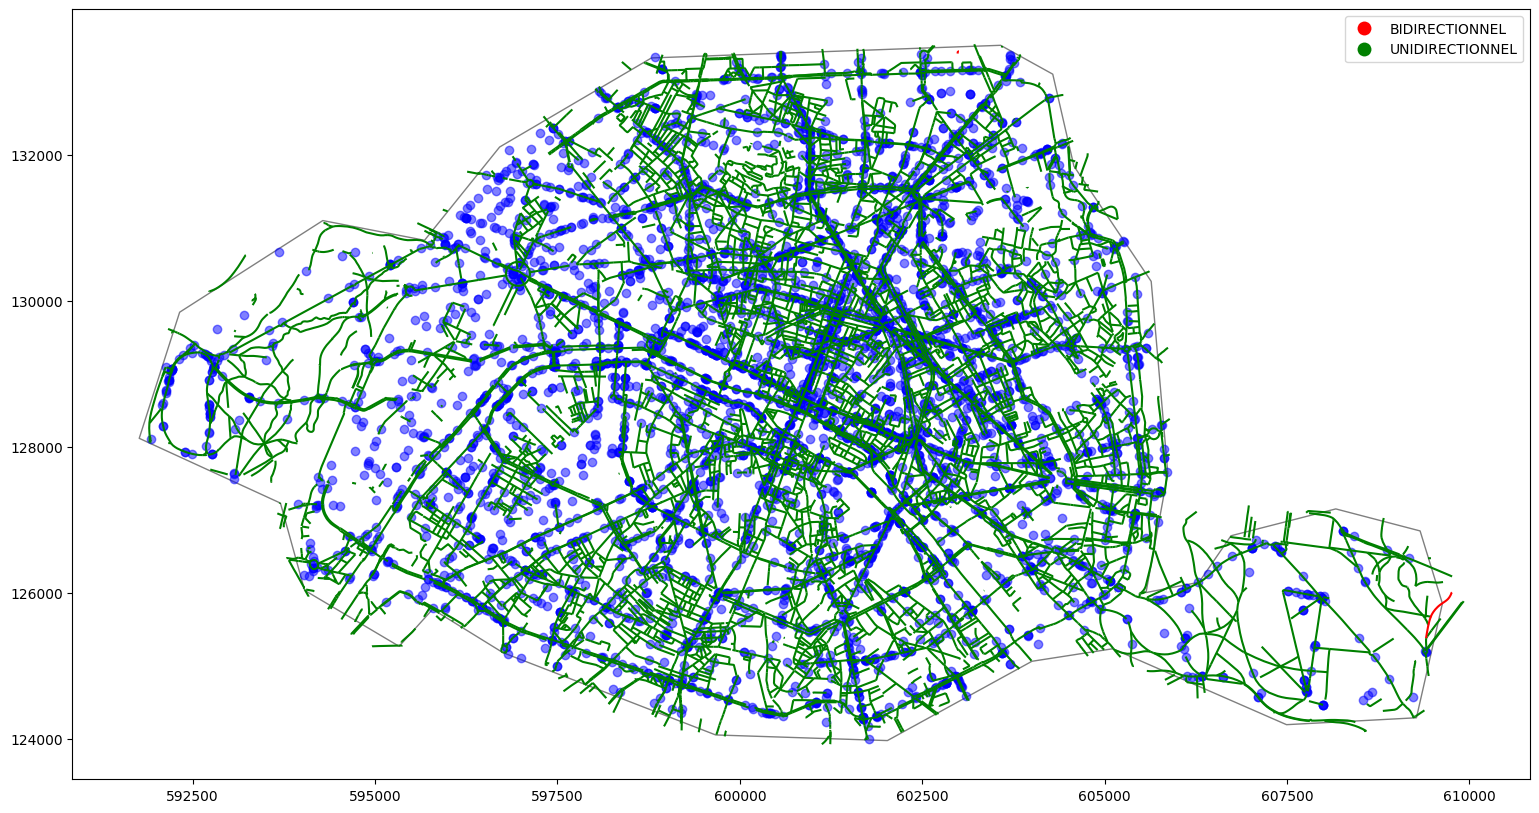

In [169]:
# Intersect tracks with paris

ax = paris.plot(color="white", edgecolor="black",alpha=0.5, figsize=(20, 10))

region_intersect_track_direction = gp.sjoin(pistes_cyclable_direction_not_na, paris, predicate='intersects')
# Intersect accidents with paris
accidents_intersect_track_direction = gp.sjoin(accidents_by_region_and_name, paris, predicate='within')
# Define a colormap
region_intersect_cmap = colors.LinearSegmentedColormap.from_list(region_intersect_track_direction["sens_d"].unique(), list(reversed(["green","red"])))

region_intersect_track_direction.plot(ax=ax,column='sens_d',cmap=region_intersect_cmap,legend=True)
accidents_intersect_track_direction.plot(ax=ax,column="age",color='blue',legend=True,alpha=0.5)



# Accidents by period of the year

In [170]:
months = list(accidents_intersect_track_direction['mois'].unique()).sort
months_order = ['janvier', 'février', 'mars', 'avril',
          'mai', 'juin', 'juillet', 'août',
          'septembre', 'octobre', 'novembre', 'décembre']

In [171]:
accidents_intersect_track_direction_grouped = accidents_intersect_track_direction.sort_values('mois', ascending=True).groupby('mois').size().reset_index(name ='Accidents')

accidents_intersect_track_direction_sorted_grouped = accidents_intersect_track_direction_grouped.sort_values('mois', key=lambda s: s.apply(months_order.index), ignore_index=True)
accidents_intersect_track_direction_sorted_grouped

mois  Accidents
0     janvier        359
1     février        319
2        mars        409
3       avril        391
4         mai        452
5        juin        623
6     juillet        519
7        août        295
8   septembre        507
9     octobre        449
10   novembre        360
11   décembre        318

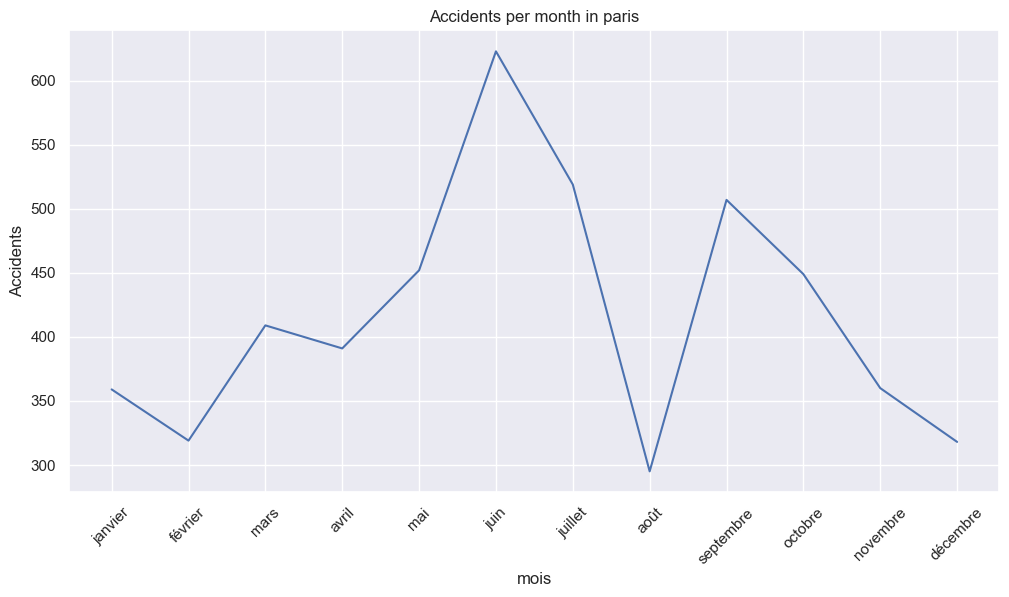

In [172]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=accidents_intersect_track_direction_sorted_grouped, x="mois",y='Accidents').set_title("Accidents per month in paris")
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

# It's cleaar that population has a hight weight on the bicycle , since during the month June and July, we have a incresed number of tourists in Paris. The month of September, is the first after vaccation in France

## Let's make cloroplets, using arrondissement zones in paris

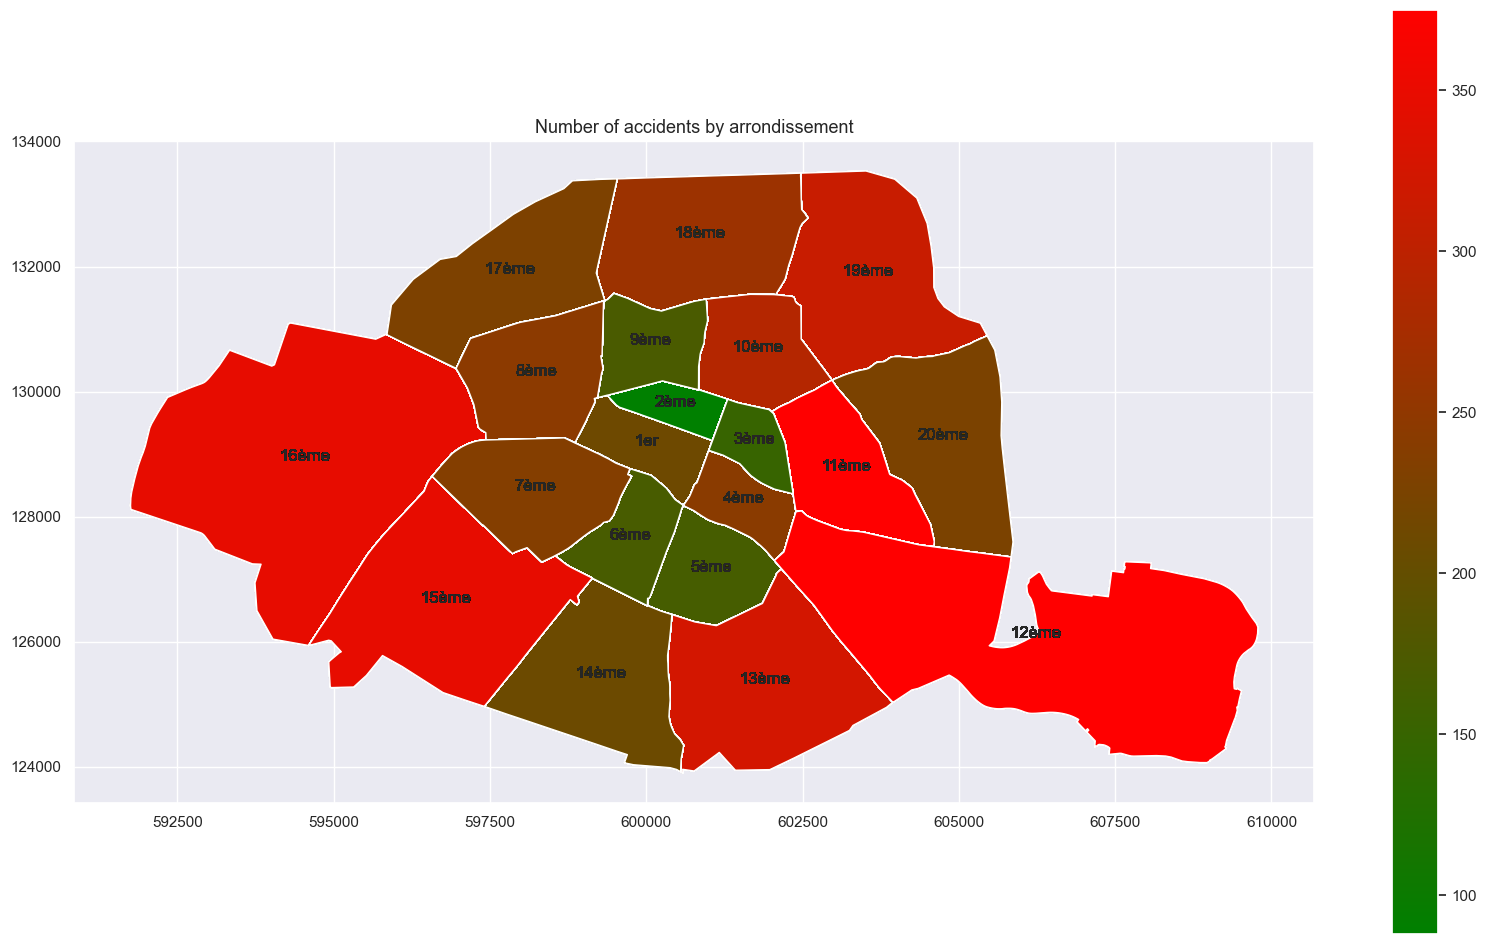

In [173]:
import geoplot as gplt


# Read polygons of arrondissement
arrondis_gdf = gp.read_file("../data/arrondissements.geojson")
arrondis_gdf = arrondis_gdf.to_crs('epsg:27561')

# Drop cols with index_ suffix
#paris_accidents = paris_accidents.loc[:,~paris_accidents.columns.str.startswith('index_')]

# Extract only accidents in paris (by name)
paris_accidents = accidents_by_department.loc[accidents_by_department['nom'] == 'Paris']

# Merge paris accidents with population data and remove cols with index_ (from merge result)
paris_accidents_by_pop2023 = paris_accidents.merge(population_filtered,on='nom')
paris_accidents_by_pop2023 = paris_accidents_by_pop2023.loc[:,~paris_accidents_by_pop2023.columns.str.startswith('index_')]

# Spatial join between arrondissement (polygon) and  accidents in paris (points), using 'intersects predicate
paris_arrondis_accidents_by_pop2023 = gp.sjoin(arrondis_gdf, paris_accidents_by_pop2023, predicate='intersects')

# Group by arronsidement names and merge with popsulation
population_by_arrondissement = paris_arrondis_accidents_by_pop2023.groupby('l_ar').size().reset_index(name='num_accidents')
paris_accidents_by_pop2023_arrondi = paris_arrondis_accidents_by_pop2023.merge(population_by_arrondissement,on='l_ar')

# Ploting result
ax = arrondis_gdf.plot(color="white",edgecolor="black",alpha=0.5, figsize=(20, 12))
paris_accidents_by_pop2023_arrondi.plot(ax=ax,column='num_accidents',cmap=region_intersect_cmap.reversed(),legend=True)

# Plot arrondissement labels based on polygons centroids
paris_accidents_by_pop2023_arrondi.apply(lambda x: ax.annotate(text= x['l_ar'].split(' ')[0], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
ax.set_title('Number of accidents by arrondissement', fontsize=13);

## And plot data

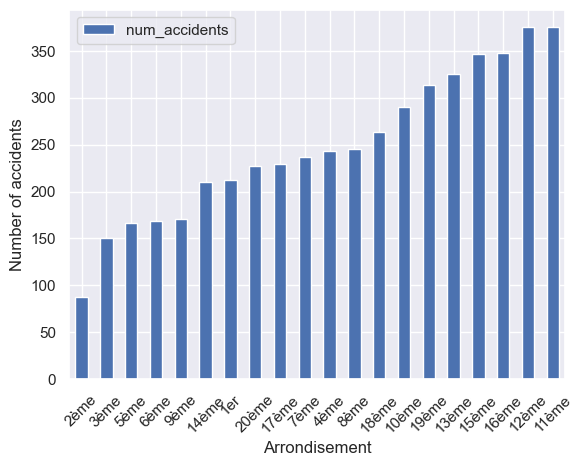

In [174]:
# Order by accident
population_by_arrondissement_ordered = population_by_arrondissement.sort_values('num_accidents')
# Split X axis labels to extract first word
labels = list(population_by_arrondissement_ordered['l_ar'].apply(lambda x: x.split(' ')[0]))

# Define an axis with plot and its parameters
ax = population_by_arrondissement.sort_values('num_accidents').plot(kind='bar',x='l_ar',
                                                               xlabel="Arrondisement",
                                                               ylabel="Number of accidents")
ax.set_xticklabels(labels,rotation=45)

# Plot
plt.show()

### They are not so representative, since we cant see where are the zones where accidents occur more ofter. Lets make a grid. A greate function can be found here : https://pygis.io/docs/e_summarize_vector.html

In [175]:
import math
import numpy as np
from shapely.geometry import Polygon, box

def create_grid(feature, shape, side_length):
    '''Create a grid consisting of either rectangles or hexagons with a specified side length that covers the extent of input feature.'''

    # Slightly displace the minimum and maximum values of the feature extent by creating a buffer
    # This decreases likelihood that a feature will fall directly on a cell boundary (in between two cells)
    # Buffer is projection dependent (due to units)
    feature = feature.buffer(20)

    # Get extent of buffered input feature
    min_x, min_y, max_x, max_y = feature.total_bounds

    # Shape area
    area = 0


    # Create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Create grid of squares if specified
    if shape in ["square", "rectangle", "box"]:

        # Adapted from https://james-brennan.github.io/posts/fast_gridding_geopandas/
        # Create and iterate through list of x values that will define column positions with specified side length
        for x in np.arange(min_x - side_length, max_x + side_length, side_length):

            # Create and iterate through list of y values that will define row positions with specified side length
            for y in np.arange(min_y - side_length, max_y + side_length, side_length):

                # Create a box with specified side length and append to list
                cells_list.append(box(x, y, x + side_length, y + side_length))
        est = (max_x - min_x) / length(cells_list)
        north = (max_y - min_y) / length(cells_list)
        area = (est * north)

    # Otherwise, create grid of hexagons
    elif shape == "hexagon":

        # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
        x_step = 1.5 * side_length

        # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
        # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
        y_step = math.sqrt(3) * side_length

        # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
        apothem = (math.sqrt(3) * side_length / 2)

        # Set column number
        column_number = 0

        # Create and iterate through list of x values that will define column positions with vertical displacement
        for x in np.arange(min_x, max_x + x_step, x_step):

            # Create and iterate through list of y values that will define column positions with horizontal displacement
            for y in np.arange(min_y, max_y + y_step, y_step):

                # Create hexagon with specified side length
                hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

                # Append hexagon to list
                cells_list.append(Polygon(hexagon))

            # Check if column number is even
            if column_number % 2 == 0:

                # If even, expand minimum and maximum y values by apothem value to vertically displace next row
                # Expand values so as to not miss any features near the feature extent
                min_y -= apothem
                max_y += apothem

            # Else, odd
            else:

                # Revert minimum and maximum y values back to original
                min_y += apothem
                max_y -= apothem

            # Increase column number by 1
            column_number += 1
        area  = (3 * math.sqrt(3) * pow(side_length,2)) / 2

    # Else, raise error
    else:
        raise Exception("Specify a rectangle or hexagon as the grid shape.")

    # Create grid from list of cells
    grid = gp.GeoDataFrame(cells_list, columns = ['geometry'], crs = "epsg:27561")

    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid,area

### Create hexagons

<Axes: >

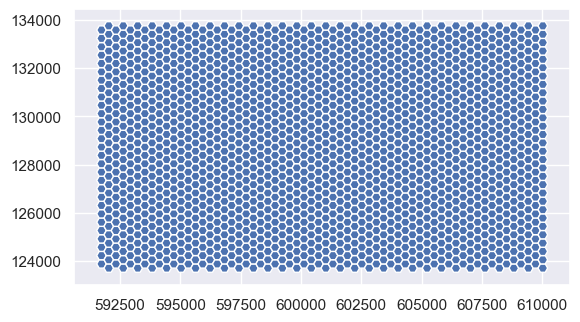

In [176]:
# Create heaxagon
area_grid,area = create_grid(feature = paris_arrondis_accidents_by_pop2023, shape = 'hexagon', side_length = 200)
#cell_grid["cell_id"] = cell_grid.index + 1
#cell_grid.head(5)
area_grid.plot()

### Remove cells outside Paris

<Axes: >

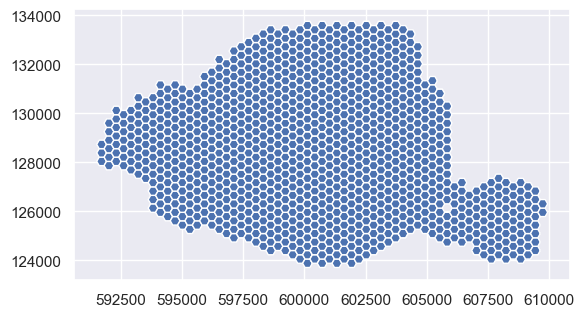

In [177]:
area_grid_paris = gp.sjoin(area_grid, arrondis_gdf, how='inner', predicate='intersects')
# Remove fields from spatial join
area_grid_paris = area_grid_paris.loc[:,~area_grid_paris.columns.str.startswith('index_')]
area_grid_paris.reset_index(inplace=True)
area_grid_paris.plot()

### Later, we fuse the cells with the accidents layer

In [178]:
## Remove index columns from previous merge operations, if necessary

paris_accidents = paris_accidents.loc[:,~paris_accidents.columns.str.startswith('index_')]
paris_accidents_by_pop2023_arrondi = paris_accidents_by_pop2023_arrondi.loc[:,~paris_accidents_by_pop2023_arrondi.columns.str.startswith('index_')]
print("Dataframes have columns with name index ? :", any(paris_accidents.columns.str.startswith('index_')) 
                                                      and any(paris_accidents_by_pop2023_arrondi.columns.str.startswith('index_')))

Dataframes have columns with name index ? : False


<Axes: >

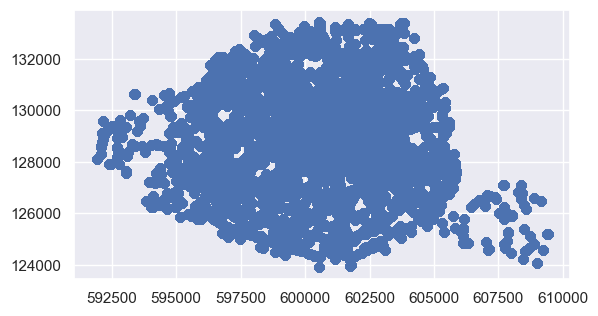

In [179]:
# Grab all dataset of accidents, within paris
accidents_paris = gp.sjoin(accidents_by_region_and_name, paris_accidents_by_pop2023_arrondi, how='inner', predicate='within')
accidents_paris = accidents_paris.loc[:,~accidents_paris.columns.str.startswith('index_')]
accidents_paris.columns = accidents_paris.columns.str.rstrip("_left")
accidents_paris.columns = accidents_paris.columns.str.rstrip("_right")

accidents_paris.plot()

In [180]:
accidents_paris.head()

num_acc          da    an       mois       jou   hrmn dep    com  \
65402  201800041647  2018-01-13  2018    janvier    samedi  21:10  94  94069   
65858  201800054676  2018-03-06  2018       mars     mardi   95:0  75  75120   
67693  201900035012  2019-06-23  2019       juin  dimanche  08:10  75  75112   
70147  202000019957  2020-12-19  2020   décembre    samedi  17:15  94  94033   
72628  202100021295  2021-09-02  2021  septembre     jeudi  08:45  75  75112   

              la       lon  ...  choc  manv       vehiculeid  typevehicules  \
65402  48.817260  2.458920  ...   0.0   1.0  202100048294A01            NaN   
65858  48.846600  2.415980  ...   0.0   1.0  202100048294A01            NaN   
67693  48.844343  2.441665  ...   0.0   1.0  202100048294A01            NaN   
70147  48.844350  2.450700  ...   0.0   1.0  202100048294A01            NaN   
72628  48.818409  2.451584  ...   0.0   1.0  202100048294A01            NaN   

       manoeuvehicules  numvehicules  code    nom  pop_2023  num_accidents  
65402              NaN           NaN    75  Paris   2102650            375  
65858              NaN           NaN    75  Paris   2102650            375  
67693              NaN           NaN    75  Paris   2102650            375  
70147              NaN           NaN    75  Paris   2102650            375  
72628              NaN           NaN    75  Paris   2102650            375  

[5 rows x 94 columns]

## Aggreate accidents by cell grid

In [181]:
#######
# Perform spatial join, merging attribute table of wells point and that of the cell with which it intersects
# op = "intersects" also counts those that fall on a cell boundary (between two cells)
# op = "within" will not count those fall on a cell boundary

points_within = points_within.loc[:,~points_within.columns.str.startswith('index_')]

# Merging accidents data with grid data by spatial intersection boundary
grid_accidents = gp.sjoin(points_within, area_grid_paris, how='left', predicate='within')

# Add a field with constant value of 1
grid_accidents['n_acc'] = 1

# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = grid_accidents.dissolve(by="index_right", aggfunc="count")

# put this into cell
area_grid_paris.loc[dissolve.index, 'n_acc'] = dissolve.n_acc.values

# Fill the NaN values (cells without any points) with 0 if we want to see
area_grid_paris['n_acc'] = area_grid_paris['n_acc'].fillna(0)
#cell_grid = cell_grid.within(paris_accidents_by_pop2023_arrondi)]


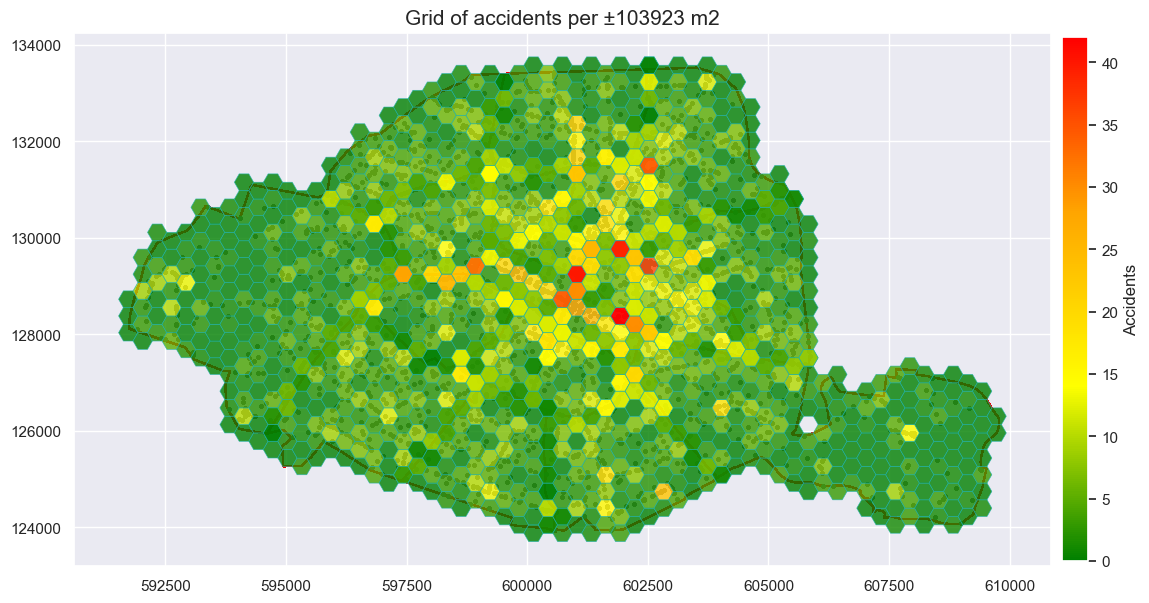

In [189]:
# Plot data
ax = paris_accidents_by_pop2023_arrondi.plot(markersize=.1, figsize=(15, 10),color="None",edgecolor="red",legend=True)
legend_intervals = [int(area_grid_paris["n_acc"].min()),5,10,15,int(area_grid_paris["n_acc"].max())]
accidents_paris.plot(ax = ax,marker = 'o', color = 'dimgray', markersize = 3)
area_grid_paris.plot(ax = ax, column = "n_acc", 
                cmap=cmap,edgecolor="lightseagreen", linewidth = 0.5, alpha = 0.8,legend = True,
                legend_kwds={
                    "shrink":.68,
                    "format": "%g",
                    'label': "Accidents",
                    "pad": 0.01,
                    #"ticks" : legend_intervals
                })
# Set title
ax.set_title(f'Grid of accidents per ±{area:.0f} m2', fontdict = {'fontsize': '15', 'fontweight' : '3'})
plt.show()

# Lets test some interpolation methods to fill the empty cells and get better results

## Give a small subset of points to train on

In [190]:
def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)


In [191]:
samples = area_grid_paris["n_acc"].to_list()

# whole range we want to plot
x_plot = np.linspace(min(samples), max(samples), len(samples))

# To make it interesting, we only give a small subset of points to train on.
x_train =  samples
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=10, replace=False))
y_train = f(x_train)

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

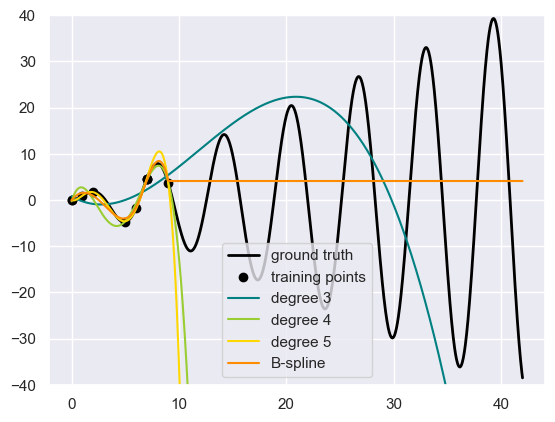

In [192]:

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

# plot function
lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_train, y_train, label="training points")

# polynomial features
for degree in [3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")
ax.legend(loc="lower center")
ax.set_ylim(-40, 40)
plt.show()


### Splines make a good job on fitting well the data, and provide the same time, some paramenters to control extrapolation. However, seasonal effects may cut an expected periodic continuation of the underlying signal. Periodic splines could be used in such case

In [193]:
def g(x):
    """Function to be approximated by periodic spline interpolation."""
    return np.sin(x) - 0.7 * np.cos(x * 3)

C:\Users\a815362\AppData\Local\Temp\ipykernel_16436\4214459259.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


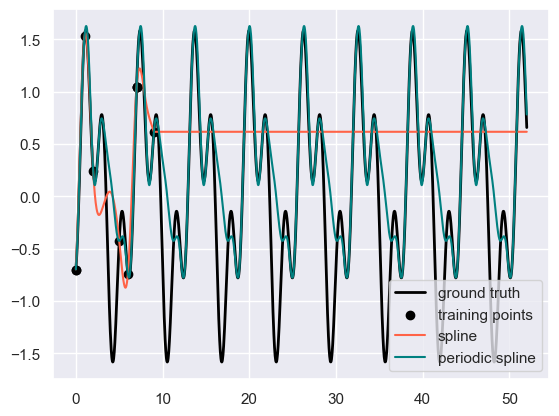

In [194]:

y_train = g(x_train)

# Extend the test data into the future:
x_plot_ext = np.linspace(min(samples), max(samples) + 10, len(samples) + 100)
X_plot_ext = x_plot_ext[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(color=["black", "tomato", "teal"])
ax.plot(x_plot_ext, g(x_plot_ext), linewidth=lw, label="ground truth")
ax.scatter(x_train, y_train, label="training points")

for transformer, label in [
    (SplineTransformer(degree=3, n_knots=10), "spline"),
    (
        SplineTransformer(
            degree=3,
            knots=np.linspace(0, 2 * np.pi, 10)[:, None],
            extrapolation="periodic",
        ),
        "periodic spline",
    ),
]:
    model = make_pipeline(transformer, Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot_ext = model.predict(X_plot_ext)
    ax.plot(x_plot_ext, y_plot_ext, label=label)

ax.legend()
fig.show()

c:\Projects\venvs\work2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Number of accidents per cell grid in Paris')

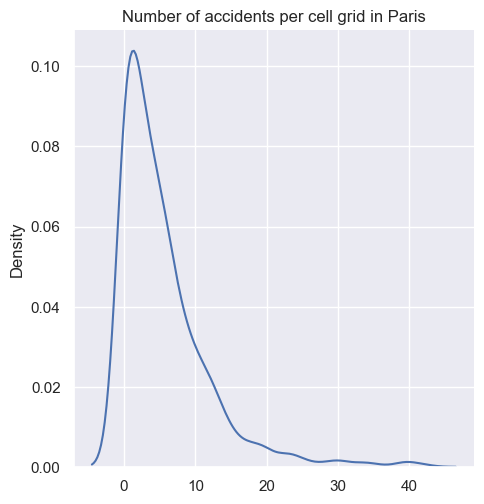

In [188]:
sns.displot(samples,kind="kde")
plt.title("Number of accidents per cell grid in Paris")